# Summarise and plot IOS analysis

In this notebook we plot the long-term average phenology across Australia, the long-term trends, and a number of plots that show the phenology time-series across Australia to show examples of change.

In [8]:
import os
import sys
import xvec
import pickle
import textwrap
import warnings
import distinctipy
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords
from _prediction import allNaN_arg

import sys
sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology_pixel import xr_phenometrics

%matplotlib inline

## Open per pixel phenology data

In [9]:
lin_or_circ = 'circular'

p_ios = assign_crs(xr.open_dataset(f'/g/data/os22/chad_tmp/Aus_phenology/results/ios_analysis_perpixel_{lin_or_circ}_final.nc'), crs='EPSG:4326')
p_average = assign_crs(xr.open_dataset(f'/g/data/os22/chad_tmp/Aus_phenology/results/mean_phenology_perpixel_{lin_or_circ}_final.nc'), crs='EPSG:4326')
p_trends = assign_crs(xr.open_dataset(f'/g/data/os22/chad_tmp/Aus_phenology/results/trends_phenology_perpixel_{lin_or_circ}_final.nc'), crs='EPSG:4326')

gdf = gpd.read_file('/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson')

# cropping for masking
crops = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc')['croplands']
crops = xr.where(crops==3, 0, 1) #rainfed crops
crops = round_coords(crops)

season_per_year = p_average['n_seasons']/p_average['n_years']
non_seasonal = xr.where((season_per_year <= 0.90),1,0)
extra_seasonal = xr.where((season_per_year >= 1.1),1,0)
seasonality_mask = (non_seasonal | extra_seasonal)

# sos_nan = np.isnan(p_trends['SOS_slope']).where(~np.isnan(p_average['SOS']))
# sos_nan = xr.where((sos_nan==1) & (seasonality_mask==0), 1, 0)
# eos_nan = np.isnan(p_trends['EOS_slope']).where(~np.isnan(p_average['EOS']))
# eos_nan = xr.where((eos_nan==1) & (seasonality_mask==0), 1, 0)
# pos_nan = np.isnan(p_trends['POS_slope']).where(~np.isnan(p_average['POS']))
# pos_nan = xr.where((pos_nan==1) & (seasonality_mask==0), 1, 0)

# extra_mask = (seasonality_mask | sos_nan | eos_nan | pos_nan)

# p_ios = p_ios[['vPOS','vSOS','vEOS','vTOS','SOS','POS','EOS','LOS','slope_IOC_vs_LOS*vPOS','pearson_r_IOC_vs_LOS*vPOS']]
# p_ios = p_ios[['vPOS','vSOS','vEOS','SOS','POS','EOS','LOS']]

In [10]:
# p_ios = p_ios.where(crops)
# p_average = p_average.where(crops)
# p_trends = p_trends.where(crops)

seasonal_vars = ['vPOS','vSOS','vEOS','SOS','POS','EOS','LOS']
# ios_most_important_var = allNaN_arg(p_ios[seasonal_vars].to_array(), dim='variable',stat='max', idx=False)
ios_most_important_var = allNaN_arg(np.abs(p_ios[seasonal_vars].to_array()), dim='variable',stat='max', idx=False)

## Partial correlations with IOS

In [11]:
val_or_time = xr.where(ios_most_important_var<=3,0, 1).where(~np.isnan(p_average['SOS'])).where(non_seasonal!=1)

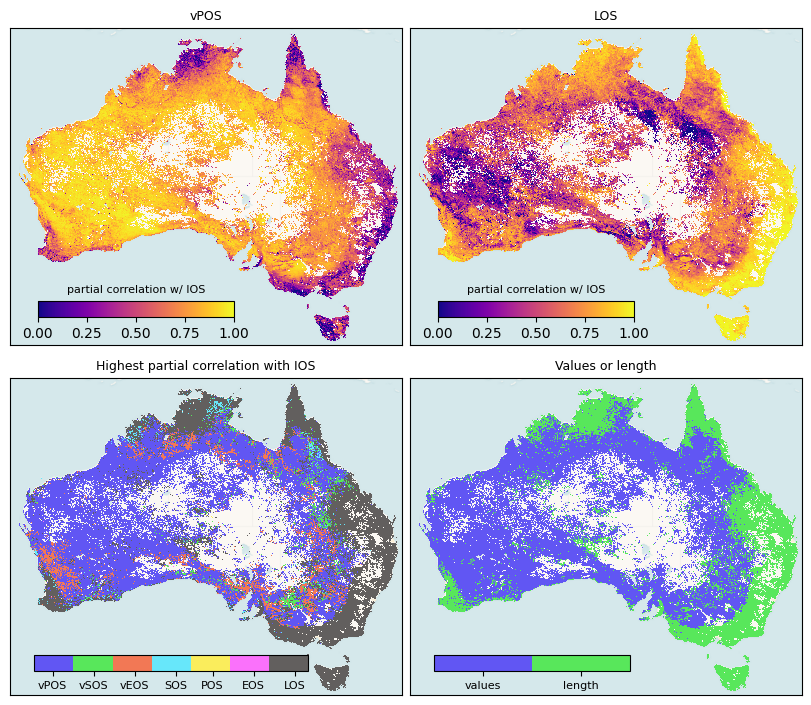

In [17]:
vars=['vPOS', 'LOS', 'Highest partial correlation with IOS', 'Values or length']

categories = seasonal_vars
colours1 = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
cmap1 = LinearSegmentedColormap.from_list("cwc", colours1, N=len(categories))

fig,axes=plt.subplots(2,2,figsize=(8,7), layout='constrained', sharey=True)

for v,ax in zip(vars, axes.ravel()):
    if v=='Highest partial correlation with IOS':
        cmap='cividis_r'
        vmin=0
        vmax=1
        t=v
        # im = ios_most_important_var.where(p_trends.vPOS_p_value <0.05).plot(ax=ax, add_colorbar=False, add_labels=False, cmap=cmap1)
        im = ios_most_important_var.where(seasonality_mask!=1).plot(ax=ax, add_colorbar=False, add_labels=False, cmap=cmap1)
        axins1 = inset_axes(ax,width="70%",height="5%",loc="lower left", borderpad=1.75)
        cbar = fig.colorbar(im, cax=axins1,  ticks=[0.4,1.3,2.2,3.1,3.9,4.8,5.7], orientation='horizontal') #ticks=[0.25,0.75]
        cbar.ax.set_xticklabels(categories, fontsize=8);

    elif v=='Values or length':
        categories = ['values', 'length']
        colours = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
        cmap = LinearSegmentedColormap.from_list("cwc", colours, N=len(categories))
        t=v
        # im = ios_most_important_var.where(p_trends.vPOS_p_value <0.05).plot(ax=ax, add_colorbar=False, add_labels=False, cmap=cmap1)
        im = val_or_time.where(seasonality_mask!=1).plot(ax=ax, add_colorbar=False, add_labels=False, cmap=cmap)
        axins1 = inset_axes(ax,width="50%",height="5%",loc="lower left", borderpad=1.75)
        cbar = fig.colorbar(im, cax=axins1,  ticks=[0.25,0.75], orientation='horizontal') #ticks=[0.25,0.75]
        cbar.ax.set_xticklabels(categories, fontsize=8);
    
    else:
        cmap='plasma'
        vmin=0
        vmax=1
        t = v
        l='partial correlation w/ IOS'
        # im=p_ios[v].where(p_trends.vPOS_p_value <0.05).plot(cmap=cmap, vmin=vmin,vmax=vmax, robust=True, ax=ax, add_labels=False,add_colorbar=False)
        im=p_ios[v].where(seasonality_mask!=1).plot(cmap=cmap, vmin=vmin,vmax=vmax, robust=True, ax=ax, add_labels=False,add_colorbar=False)
        axins1 = inset_axes(ax,width="50%",height="5%",loc="lower left", borderpad=2)
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        ax_cbar = fig.colorbar(cbar, ax=ax, cax=axins1, orientation='horizontal')
        ax_cbar.ax.set_title(l, fontsize=8)
    
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_title(t, fontsize=9)
    
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/IOS_parcorr.png',
            bbox_inches='tight', dpi=300)

In [18]:
val_or_time.odc.explore(
            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
           attr = 'Esri',
           name = 'Esri Satellite',
    cmap=cmap1,
)

## Examples of disconnection between positive vPOS trends and IOC


In [ ]:
base = '/g/data/os22/chad_tmp/Aus_phenology/'
ds_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022.nc'
timeseries_file =f'{base}data/pickle/IBRA_subregions_climate.pkl'
gdf = gpd.read_file('/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson')
phenometrics_file = f'{base}data/pickle/IBRA_subregions_AusENDVI-clim_MCD43A4_phenometrics_new.pkl'
var='SUB_NAME_7'

with open(phenometrics_file, 'rb') as f:
    phenometrics = pickle.load(f)

gdf = gdf[gdf[var].isin(list(phenometrics.keys()))]

In [ ]:
# gdf.explore( tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#            attr = 'Esri',
#            name = 'Esri Satellite',
#            )

In [ ]:
disconnected_from_vPOS = ['Daintree-Bloomfield', 'Warre',  'Otway Ranges', 'West'] #South East Coastal Ranges 'Dalmorto', Weipa Plateau Coffs Coast and Escarpment
# disconnected_from_vPOS = ['Bogie River Hills', 'Daintree-Bloomfield', 'Weipa Plateau', 'Dalmorto', 'Otway Ranges', 'West'] 
connected_to_vPOS = ['Claraville Plains', 'Newcastle', 'Berkeley', 'Carlisle']

gdf_dis = gdf[gdf['SUB_NAME_7'].isin(disconnected_from_vPOS)].reset_index(drop=True)

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(8,5), sharex=True, layout='constrained')
roll=5
for region, ax in zip(connected_to_vPOS, axes.ravel()):
    df = phenometrics[region]
    vpos=((df.vPOS - df.vPOS.mean()) / df.vPOS.std())
    vpos = vpos.rolling(roll).mean()
    vpos.plot(ax=ax, label='vPOS')
    los = ((df.LOS - df.LOS.mean()) / df.LOS.std())
    los = los.rolling(roll).mean()
    los.plot(ax=ax, label='LOS')
    ios = ((df.IOC - df.IOC.mean()) / df.IOC.std())
    ios = ios.rolling(roll).mean()
    ios.plot(ax=ax, label='IOS', c='black', linestyle='--')
    ax.grid(alpha=0.75)
    ax.set_title(region)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.legend()
    ax.set_xticks(ticks = range(0,40, 6), labels=range(1982,2022, 6));
fig.supylabel('z-score');

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(8,5), sharex=True,  layout='constrained')
roll=5
for region, ax in zip(disconnected_from_vPOS, axes.ravel()):
    df = phenometrics[region]
    # df = df.rolling(10).mean()
    vpos=((df.vPOS - df.vPOS.mean()) / df.vPOS.std())
    vpos = vpos.rolling(roll).mean()
    vpos.plot(ax=ax, label='vPOS')
    los = ((df.LOS - df.LOS.mean()) / df.LOS.std())
    los = los.rolling(roll).mean()
    los.plot(ax=ax, label='LOS')
    ios = ((df.IOS - df.IOS.mean()) / df.IOS.std())
    ios = ios.rolling(roll).mean()
    ios.plot(ax=ax, label='IOS', c='black', linestyle='--')
    ax.grid(alpha=0.75)
    ax.set_title(region)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.legend()
    ax.set_xticks(ticks = range(0,40, 6), labels=range(1982,2022, 6));
fig.supylabel('z-score');

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(7,7))
gdf_dis = gdf[gdf['SUB_NAME_7'].isin(disconnected_from_vPOS + connected_to_vPOS)].reset_index(drop=True)
gdf.plot(column='SUB_NAME_7', ax=ax, legend=False, edgecolor="white", linewidth=0.005,facecolor='none')
gdf_dis.plot(column='SUB_NAME_7', ax=ax, legend=True, legend_kwds ={'ncols':2, 'loc':'lower left', 'fontsize':8})
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([]);

### Is this a trend for all high tree fraction regions?

In [ ]:
trees = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/trees_5km_monthly_1982_2022.nc')['trees']
trees = trees.mean('time')
tree_mask = xr.where(trees>=0.5, 1, 0)

#and significant change in vPOS
tree_mask = ((tree_mask) & (p_trends.vPOS_p_value <=0.05))

In [ ]:
ds_path = '/g/data/os22/chad_tmp/Aus_phenology/data/NDVI/NDVI_smooth_AusENDVI-clim_MCD43A4.nc'
ds = xr.open_dataarray(ds_path)
ds = ds.where(tree_mask)
ds = ds.mean(['latitude', 'longitude'])
times_to_keep = ds.dropna(dim='time',how='any').time
ds = ds.sel(time=times_to_keep)
ds = ds.resample(time='1D').interpolate(kind='quadratic').astype('float32')

In [ ]:
#run the phenometrics
ds_phen= xr_phenometrics(ds.expand_dims(latitude=[-33], longitude = [125]),
                  rolling=90,
                  distance=90,
                  prominence='auto',
                  plateau_size=10,
                  amplitude=0.20,
                  soil_signal = 0.14
                 ).compute()
        

In [ ]:
layout = [
    ['A','A' ,'B', 'B','B'],
]

fig, ax = plt.subplot_mosaic(layout, figsize=(15, 4))

df = ds_phen.squeeze().to_dataframe()
# df = df.rolling(5).mean()
tree_mask.where(tree_mask==1).plot(ax=ax['A'], add_colorbar=False, add_labels=False)
ctx.add_basemap(ax['A'], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax['A'].axes.get_xaxis().set_ticks([])
ax['A'].axes.get_yaxis().set_ticks([])
ax['A'].set_title('Tree fraction >= 0.5 & vPOS p-value < 0.05')

roll=1
vpos=((df.vPOS - df.vPOS.mean()) / df.vPOS.std())
vpos = vpos.rolling(roll).mean()
vpos.plot(ax=ax['B'], label='vPOS')
los = ((df.LOS - df.LOS.mean()) / df.LOS.std())
los = los.rolling(roll).mean()
los.plot(ax=ax['B'], label='LOS')
ios = ((df.IOC - df.IOC.mean()) / df.IOC.std())
ios = ios.rolling(roll).mean()
ios.plot(ax=ax['B'], label='IOS', c='black', linestyle='--')

ax['B'].grid(alpha=0.75)
ax['B'].set_xlabel(None)
ax['B'].set_ylabel('z-score',fontsize=12)
ax['B'].legend()
ax['B'].set_xticks(ticks = range(0,40, 6), labels=range(1982,2022, 6));

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(7,7))
ios_most_important_var.where(p_trends.IOS_p_value <0.05).plot(cmap=cmap1, ax=ax, add_colorbar=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

In [ ]:



# gdf_dis.explore(col='SUB_NAME_7',
#             tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#             attr = 'Esri',
#             name = 'Esri Satellite',
#            )

## IOS and vPOS*LOS

In [ ]:
median_corr = p_ios['pearson_r_IOC_vs_LOS*vPOS'].median()

In [ ]:
vars=['IOC', 'LOS*vPOS','IOC:(LOS*vPOS)', 'pearson_r_IOC_vs_LOS*vPOS']

fig,axes=plt.subplots(2,2,figsize=(10,7), layout='constrained', sharey=True)

for v,ax in zip(vars, axes.ravel()):
    if v=='IOC:(LOS*vPOS)':
        cmap='cividis'
        vmin=0.5
        vmax=1
        t=v
        l='ratio'

    if any(v in s for s in ['IOC','LOS*vPOS']):
        cmap='inferno'
        vmin=0
        vmax=200
        t = v
        l='NDVI\nyr⁻¹'
    
    if v == 'pearson_r_IOC_vs_LOS*vPOS':
        cmap='viridis'
        vmin=0.5
        vmax=1
        t=f'Correlation IOC & vPOS*LOS, median = {median_corr.values.item():.2f}'
        l='Pearson\nR'

    if v == 'pearson_r_IOC_vs_LOS*vPOS':
        im=p_ios[v].plot(cmap=cmap, vmin=vmin,vmax=vmax, robust=True, ax=ax, add_labels=False,add_colorbar=False)
    
    else:
        im=p_average[v].plot(cmap=cmap, vmin=vmin,vmax=vmax, robust=True, ax=ax, add_labels=False,add_colorbar=False)
    
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_title(t, fontsize=12)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.7)
    ax_cbar.ax.set_title(l, fontsize=8)
    
# fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/IOS_LOSvPOS_ratio.png',
#             bbox_inches='tight', dpi=300)

In [ ]:
# region='Wilto'

# for index, row in gdf.iterrows():
#     if row[var] == region:
#         df = phenometrics[row[var]]
#         # df = df.rolling(5).mean()

# fig,ax = plt.subplots(1,1, figsize=(7,4), sharex=True)
# ((df.vPOS - df.vPOS.mean()) / df.vPOS.std()).plot(ax=ax, label='vPOS')
# ((df.LOS - df.LOS.mean()) / df.LOS.std()).plot(ax=ax, label='LOS')
# ((df.IOS - df.IOS.mean()) / df.IOS.std()).plot(ax=ax, label='IOS', c='black', linestyle='--')
# ax.grid(alpha=0.75)
# ax.set_title(region)
# ax.legend()
# ax.set_ylabel('z-score')
# ax.set_xticks(ticks = range(0,40, 6), labels=range(1982,2022, 6));
# # ax.set_ylim(-2,2)
